In [1]:
import sys
sys.path.append('..')
import torch
from torchvision import datasets, transforms
from models import VAE, loss_function
from problems import get_problem
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

p = get_problem('sum_25', 'int', train_ratio=1.)

def get_digit(digit, train):
    test_digits = []
    for data, label in datasets.MNIST('../data', train=train, download=True, transform=transforms.ToTensor()):
        if digit == -1 or label.item() == digit:
            test_digits.append((data, label))
    return test_digits

In [43]:
# Load all VAES
vaes = {}
for i in xrange(10):
    vae = VAE()
    state_dict = torch.load('digit_{}_epoch_80.pth'.format(i))
    vae.load_state_dict(state_dict)
    vaes[i] = vae
    
# Build visual models (from VAEs)
def create_visual_model(digit_idx, vaes):
    def visual_model(digit_image):
        x = digit_image.view((1, 1, 28, 28))
        reconstruction, mu, logvar = vaes[digit_idx](x)
        nll = loss_function(reconstruction, x, mu, logvar)
        return nll
    return visual_model
visual_models = [create_visual_model(i, vaes) for i in xrange(10)]

In [33]:
# Load all MNISTs
batch_size = 1

# Load all MNIST digits
test_digits = {}
test_loaders = {}
for i in xrange(10):
    print 'Loading digit', i
    test_digit = get_digit(i, train=False)
    test_digits[i] = test_digit
    
    test_loader = torch.utils.data.DataLoader(test_digit, batch_size=batch_size, shuffle=True)
    test_loaders[i] = test_loader
    
# Build visual samplers (from test set)
def create_visual_sampler(i, test_loaders):
    def visual_sampler():
        return iter(test_loaders[int(i)]).next()[0][0,0]
    return visual_sampler
visual_samplers = [create_visual_sampler(i, test_loaders) for i in xrange(10)]

print visual_samplers[8]().size()

Loading digit 0
Loading digit 1
Loading digit 2
Loading digit 3
Loading digit 4
Loading digit 5
Loading digit 6
Loading digit 7
Loading digit 8
Loading digit 9
torch.Size([28, 28])


# Symbolic Combination to Image Combination

Size torch.Size([5, 28, 28])


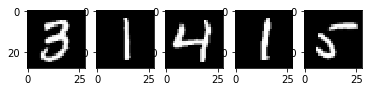

In [69]:
# Combination to Visual
def to_visual(combination, visual_samplers):
    '''
    Sample a visual representation for a symbolic combination
    
    Parameters
    ----------
    combination: np.ndarray (part~5) combination to encode
    visual_samplers: dict of 10 callable objects which return a random corresponding (28, 28) digit
    
    Returns
    -------
    visual_combination: torch.Tensor (part~5, height~28, width~28)
    '''
    x = []
    for c in combination:
        sample = visual_samplers[c]()
        x.append(sample[None, :, :])
    visual_combination = torch.cat(x)
    return visual_combination

# Test: combination to visual_combination    
visual_combination = to_visual([3, 1, 4, 1, 5], visual_samplers)

print 'Size', visual_combination.size()
for i in xrange(5):
    plt.subplot(1,5,i+1)
    plt.imshow(visual_combination[i].numpy(), cmap='gray')

# Likelihood of Sum-25 with Joint generator

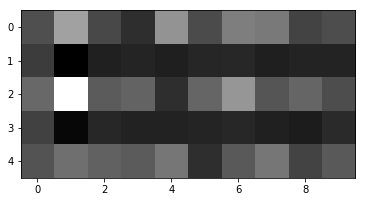

In [70]:
# Precompute conditional visual likelihoods
def get_per_digit_likelihood(visual_combination, visual_models):  # return -log likelihoods
    '''
    Compute NLL given by each visual model (e.g. VAE) to each visual digit.
    
    Parameters
    ----------
    visual_combination: torch.Tensor (part~5, height~28, width~28)
    visual_models: dictionary of objects which can be called on x and return a nll

    Return
    ------
    visual_likelihoods: np.ndarray (part~5, digit~10)
    ''' 
    visual_likelihoods = np.zeros((5, 10))
    for part in xrange(5):
        for model_idx in xrange(10):
            digit_image = visual_combination[part]
            l = visual_models[model_idx](digit_image)
            visual_likelihoods[part, model_idx] = l  # since it's -log likelihood
    return visual_likelihoods

# Test: get conditional nll for each digit of visual combination
visual_likelihoods = get_per_digit_likelihood(visual_combination, visual_models)
plt.imshow(visual_likelihoods, 'gray')


In [72]:
# Sum over all combinations in symbolic model
conditional_likelihoods = []

def log_sum_exp(v):
    v = np.asarray(v)
    v_max = v.max()
    return v_max + np.log(np.sum(np.exp(v - v_max)))


def get_one_sample_likelihood(visual_likelihoods, model_combinations):
    '''
    Return likelihood given by a joint model for one visual sample.
    
    Parameters
    ----------
    visual_likelihoods: np.ndarray (part~5, digit~10) of per_digit likelihoods
    model_combinations: np.ndarray (combination~1000, part~5) 
        symbolic model is uniform distribution on those combinations.
    
    Returns
    -------
    likelihood: nll for that given sample: -log { 1/|C| sum_{z\in C} p(z) \prod_i p(x_i | z_i) }
    conditional_likelihoods: -\sum_i \log p(x_i | z_i)
    closest_combination: return combination z in model_combinations with highest likelihood
    '''
    conditional_likelihoods = []
    for combination in model_combinations:  # iterate over possible z
        tmp = 0.
        for part, c in enumerate(combination):
            p_xPart_given_zPart = visual_likelihoods[part, c]
            tmp += p_xPart_given_zPart
        conditional_likelihoods.append(tmp)
    likelihood = np.log(len(model_combinations)) - log_sum_exp(-np.asarray(conditional_likelihoods))  # get NLL
    # for debugging return closest combination
    best_x_z = np.argmin(conditional_likelihoods)  # smallest log likelihood
    closest_combination = model_combinations[best_x_z]
    return likelihood, conditional_likelihoods, closest_combination
    
    
# Test: get liklelihood for sample giving visual_likelihood
likelihood, conditional_likelihoods, closest_combination = get_one_sample_likelihood(
    visual_likelihoods, sum_25.train_positive)

# Note that the largest conditional likelihood should correspond classifying the combination
# if combination verifies constraint
print 'Closest combination match', closest_combination
print 'Likelihood', likelihood

Closest combination match [8 1 4 7 5]
Likelihood 480.8917940786185


# Repeat this over all training set combinations X model combinations
[Main Function]

In [73]:
def get_likelihood(target_combinations, model_combinations,
                    visual_samplers, visual_models, max_iterations=200):
    '''
    Return estimated likelihood for 
    '''
    all_likelihoods = []
    for i, combination in enumerate(target_combinations):  # true distribution to reach
        
        if i >= max_iterations:
            break
        
        # Transform symbolic combination to visual
        visual_combination = to_visual(combination, visual_samplers)
        
        # Compute likelihood of each part(digit) with each visual conditional model 
        visual_likelihoods = get_per_digit_likelihood(visual_combination, visual_models)  
        
        # Compute likelihood of that visual sample
        likelihood, conditional_likelihoods, closest_combination = get_one_sample_likelihood(
            visual_likelihoods, model_combinations)  # model distribution

        # Logging
        all_likelihoods.append(likelihood)
        average_nll = np.mean(all_likelihoods)
        std = np.std(all_likelihoods) / np.sqrt(len(all_likelihoods))
        if i % 50 == 0:
            print 'Combination #', i
            print 'Combination', combination
            print 'closest', closest_combination
            print 'Likelihood', likelihood
            print 'NLL in [{:.1f}; {:.1f}]'.format(average_nll-std, average_nll+std)  
            
    return average_nll, std

target_combinations = sum_25.train_positive
model_combinations = sum_25.train_positive
average_nll, std = get_likelihood(target_combinations, model_combinations,
                    visual_samplers, visual_models, max_iterations=200)

print 'NLL in [{:.1f}; {:.1f}]'.format(average_nll-std, average_nll+std)

Combination # 0
Combination [0 9 7 1 8]
closest [0 9 7 1 8]
Likelihood 414.54120895123117
NLL in [414.5; 414.5]
Combination # 50
Combination [7 3 3 6 6]
closest [7 3 3 6 6]
Likelihood 503.4504725620709
NLL in [471.3; 484.7]
Combination # 100
Combination [0 9 8 6 2]
closest [0 9 8 6 2]
Likelihood 490.0774409458601
NLL in [472.2; 483.1]


KeyboardInterrupt: 

# Actual tests

In [64]:
uniform = get_problem('uniform', 'int', train_ratio=1.)
sum_25 = get_problem('sum_25', 'int', train_ratio=1.)
increasing = get_problem('increasing', 'int', train_ratio=1.)
symmetric = get_problem('symmetric', 'int', train_ratio=1.)
even = get_problem('even', 'int', train_ratio=1.)
max_iterations = 1000

In [62]:
target_combinations = sum_25.train_positive
model_combinations = uniform.train_positive
average_nll, std = get_likelihood(target_combinations, model_combinations,
                    visual_samplers, visual_models, max_iterations=max_iterations)

Combination # 0
Combination [4 9 2 6 4]
closest [4 9 2 6 4]
Likelihood 512.8090463283489
NLL in [512.8; 512.8]
Combination # 50
Combination [6 9 1 1 8]
closest [6 9 1 1 8]
Likelihood 408.1350825258789
NLL in [487.8; 501.6]
Combination # 100
Combination [0 3 7 8 7]
closest [0 3 7 8 7]
Likelihood 467.807421414116
NLL in [493.5; 503.4]
Combination # 150
Combination [8 7 5 3 2]
closest [8 7 5 3 2]
Likelihood 535.4308906091618
NLL in [489.8; 498.3]


In [63]:
target_combinations = sum_25.train_positive
model_combinations = uniform.train_positive
average_nll, std = get_likelihood(target_combinations, model_combinations,
                    visual_samplers, visual_models, max_iterations=200)

Combination # 0
Combination [4 9 2 6 4]
closest [4 5 2 6 4]
Likelihood 516.9421055931618
NLL in [516.9; 516.9]
Combination # 50
Combination [6 9 1 1 8]
closest [6 9 1 1 9]
Likelihood 461.985123104113
NLL in [481.4; 492.5]
Combination # 100
Combination [0 3 7 8 7]
closest [0 3 7 8 7]
Likelihood 517.2286555454691
NLL in [485.3; 493.9]
Combination # 150
Combination [8 7 5 3 2]
closest [8 7 5 3 2]
Likelihood 521.1744486971652
NLL in [483.0; 491.1]


In [83]:
all_problems = ['sum_25', 'increasing', 'symmetric', 'even']
uniform = get_problem('uniform', 'int', train_ratio=1.)
max_iterations = 2000

# (key_1, key_2) key_1 is target, key_2 is model
average_nlls = {}
stds = {}

for p in all_problems:
    target_problem = get_problem(p, 'int', train_ratio=1.)
    # Compute target vs. uniform model
    print '\n{} with {}-model'.format(p, 'UNIFORM')
    average_nll, std = get_likelihood(target_problem.train_positive, uniform.train_positive,
                    visual_samplers, visual_models, max_iterations=max_iterations)
    average_nlls[(p, 'uniform')] = average_nll
    stds[(p, 'uniform')] = std
    # Compute target vs. target model
    print '\n{} with {}-model'.format(p, p)
    average_nll, std = get_likelihood(target_problem.train_positive, target_problem.train_positive,
                    visual_samplers, visual_models, max_iterations=max_iterations)
    average_nlls[(p, p)] = average_nll
    stds[(p, p)] = std    
    


sum_25 with UNIFORM-model
Combination # 0
Combination [2 9 4 4 6]
closest [2 9 4 4 6]
Likelihood 522.4075787852826
NLL in [522.4; 522.4]
Combination # 50
Combination [5 5 7 1 7]
closest [5 5 7 1 7]
Likelihood 440.8647092174079
NLL in [476.2; 490.4]
Combination # 100
Combination [7 2 7 1 8]
closest [7 2 7 1 8]
Likelihood 416.09948094591977
NLL in [478.3; 488.9]
Combination # 150
Combination [5 3 5 8 4]
closest [5 3 5 8 4]
Likelihood 549.0760281870936
NLL in [478.9; 487.2]
Combination # 200
Combination [5 4 5 8 3]
closest [5 4 5 8 3]
Likelihood 565.5682683724028
NLL in [481.4; 488.5]
Combination # 250
Combination [8 1 5 8 3]
closest [8 1 5 8 3]
Likelihood 533.5882771798732
NLL in [482.7; 489.3]
Combination # 300
Combination [5 8 9 2 1]
closest [5 8 9 2 1]
Likelihood 478.9353150256005
NLL in [482.8; 488.8]
Combination # 350
Combination [8 5 9 1 2]
closest [8 5 9 1 8]
Likelihood 555.4661154248765
NLL in [482.5; 488.2]
Combination # 400
Combination [3 8 9 4 1]
closest [3 8 9 4 1]
Likelihoo

Combination # 1600
Combination [7 7 4 0 7]
closest [7 7 4 0 7]
Likelihood 460.18599960064523
NLL in [481.7; 484.4]
Combination # 1650
Combination [6 4 7 0 8]
closest [6 4 7 0 8]
Likelihood 518.6728465244734
NLL in [481.9; 484.5]
Combination # 1700
Combination [4 8 6 7 0]
closest [4 8 6 7 0]
Likelihood 515.0096995518128
NLL in [481.9; 484.5]
Combination # 1750
Combination [0 4 5 9 7]
closest [0 4 5 9 7]
Likelihood 478.41106672961854
NLL in [482.1; 484.7]
Combination # 1800
Combination [0 7 3 8 7]
closest [0 7 3 8 7]
Likelihood 452.7889201328718
NLL in [481.9; 484.4]
Combination # 1850
Combination [8 2 6 0 9]
closest [8 2 8 0 7]
Likelihood 554.8311924204744
NLL in [482.1; 484.6]
Combination # 1900
Combination [4 5 0 7 9]
closest [4 5 0 7 9]
Likelihood 537.1239649937116
NLL in [482.4; 484.8]
Combination # 1950
Combination [3 2 5 7 8]
closest [3 2 5 7 8]
Likelihood 520.2536112949812
NLL in [482.4; 484.8]

increasing with UNIFORM-model
Combination # 0
Combination [5 7 8 8 9]
closest [5 7 8 

Combination # 1200
Combination [0 1 2 4 8]
closest [0 1 2 4 8]
Likelihood 486.71605296085175
NLL in [475.6; 479.1]
Combination # 1250
Combination [2 5 7 7 8]
closest [2 2 7 7 8]
Likelihood 521.6883149683281
NLL in [476.2; 479.6]
Combination # 1300
Combination [0 1 4 5 6]
closest [0 1 4 5 6]
Likelihood 462.6950416083127
NLL in [476.5; 479.9]
Combination # 1350
Combination [0 3 5 6 8]
closest [0 3 5 6 8]
Likelihood 521.0254623501163
NLL in [476.6; 479.9]
Combination # 1400
Combination [5 5 5 6 6]
closest [5 5 5 6 6]
Likelihood 497.61055369327363
NLL in [476.8; 480.1]
Combination # 1450
Combination [0 2 3 3 5]
closest [0 2 3 3 5]
Likelihood 516.2467536420803
NLL in [476.9; 480.1]
Combination # 1500
Combination [0 1 2 4 7]
closest [0 1 2 4 7]
Likelihood 471.9533538336545
NLL in [477.2; 480.3]
Combination # 1550
Combination [0 2 3 3 4]
closest [0 2 3 3 4]
Likelihood 567.0886878485469
NLL in [477.7; 480.8]
Combination # 1600
Combination [2 5 8 9 9]
closest [2 5 8 9 9]
Likelihood 507.45853032

Combination # 800
Combination [7 4 4 2 9]
closest [7 4 4 2 9]
Likelihood 443.38410336729567
NLL in [481.0; 485.0]
Combination # 850
Combination [9 6 4 7 0]
closest [9 6 4 7 0]
Likelihood 488.65434821118816
NLL in [480.8; 484.7]
Combination # 900
Combination [2 2 2 7 5]
closest [2 2 2 7 5]
Likelihood 527.262597400481
NLL in [481.1; 484.8]
Combination # 950
Combination [4 9 8 8 1]
closest [4 9 8 8 1]
Likelihood 487.7923709527626
NLL in [480.9; 484.6]
Combination # 1000
Combination [8 5 8 8 7]
closest [8 5 3 8 7]
Likelihood 589.7368078797477
NLL in [481.3; 484.8]
Combination # 1050
Combination [1 8 3 6 2]
closest [1 8 3 6 2]
Likelihood 447.6481154269997
NLL in [481.9; 485.3]
Combination # 1100
Combination [6 5 1 5 3]
closest [6 5 1 8 3]
Likelihood 400.2920125290794
NLL in [482.0; 485.3]
Combination # 1150
Combination [8 5 1 5 9]
closest [8 5 1 5 9]
Likelihood 484.54189792191573
NLL in [481.6; 484.9]
Combination # 1200
Combination [7 9 5 6 1]
closest [7 9 5 6 1]
Likelihood 465.901893771425

In [84]:
average_nlls

{('even', 'even'): 481.91181570206373,
 ('even', 'uniform'): 482.9734683909112,
 ('increasing', 'increasing'): 479.4476960012851,
 ('increasing', 'uniform'): 484.41127030128615,
 ('sum_25', 'sum_25'): 483.67355286559086,
 ('sum_25', 'uniform'): 484.50117134723274,
 ('symmetric', 'symmetric'): 479.8533984685067,
 ('symmetric', 'uniform'): 484.1185003963396}

In [85]:
stds

{('even', 'even'): 1.2171978858548096,
 ('even', 'uniform'): 1.2668743925587675,
 ('increasing', 'increasing'): 1.3597330309634366,
 ('increasing', 'uniform'): 1.4075802609068047,
 ('sum_25', 'sum_25'): 1.1829772798830123,
 ('sum_25', 'uniform'): 1.1818917495160075,
 ('symmetric', 'symmetric'): 2.1689768139683823,
 ('symmetric', 'uniform'): 2.076468640541826}

In [88]:
lines = []
for key in average_nlls:
    lines.append('{}: {:.1f} +/- {:.1f}'.format(key, average_nlls[key], stds[key]))
lines = sorted(lines)
print '\n'.join(lines)

('even', 'even'): 481.9 +/- 1.2
('even', 'uniform'): 483.0 +/- 1.3
('increasing', 'increasing'): 479.4 +/- 1.4
('increasing', 'uniform'): 484.4 +/- 1.4
('sum_25', 'sum_25'): 483.7 +/- 1.2
('sum_25', 'uniform'): 484.5 +/- 1.2
('symmetric', 'symmetric'): 479.9 +/- 2.2
('symmetric', 'uniform'): 484.1 +/- 2.1


In [ ]:
key